# Setup
We will load all the necessary libraries.

In [23]:
from sklearn import datasets
import pandas as pd
import numpy as np
import math
import random
from numpy_ml import neural_nets
import plotly.express as px
import plotly.graph_objects as go
import wandb
import os

os.environ["WANDB_SILENT"] = "true"

# Data

In this experiment, we'll be using the Iris dataset. The iris dataset has 150 entries, each of them having four attributes. There are no missing values in the dataset, and each data entry maps one of the three possible classes.
1. Iris Setosa
2. Iris Versicolour
3. Iris Versicolour

In [24]:
iris = datasets.load_iris()

def onhot_encoder(y):
    y_oh = np.zeros((y.size, y.max() + 1))
    y_oh[np.arange(y.size), y] = 1
    return y_oh

# data
x_train = iris.data
print(f"Training Data Shape: {x_train.shape}")

# ṭarget
y_train = iris.target
print(f"Training Label Shape: {y_train.shape}")

# Used for testing
y_train_oh = onhot_encoder(y_train)

# TODO: Split data into training and testing set

Training Data Shape: (150, 4)
Training Label Shape: (150,)


# Neural Network
In this section, we'll be defining the neural network that we will be using for our experiment.

## Utility functions

In [25]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def ReLU(x):
    return np.maximum(0,x)

def dReLU(x):
    return 1 * (x > 0) 

def softmax(z):
    z = z - np.max(z, axis = 1).reshape(z.shape[0],1)
    return np.exp(z) / np.sum(np.exp(z), axis = 1).reshape(z.shape[0],1)

def stable_softmax(z):
    exps = np.exp(z - np.max(z))
    return exps / np.sum(exps)

def activation(x, w, b):
    return sigmoid(np.dot(x, w)+b)


## The Network

In [26]:
class NN:
    def __init__(self, input_size, output_size, hidden_shape):
        self.nodes = hidden_shape
        self.params = []
        self.biases = []
        self.total_num_params = 0

        assert len(hidden_shape) > 0
        assert input_size > 0
        assert output_size > 0

        # Creating the network
        nn_last_layer_size = None
        for hidden_size in hidden_shape:
            nn_in_size = input_size if nn_last_layer_size is None else nn_last_layer_size
            nn_out_size = hidden_size
            
            self.params.append(np.random.randn(nn_in_size, nn_out_size))
            self.biases.append(np.random.randn(nn_out_size,))

            nn_last_layer_size = nn_out_size

            # storing dims for later
            self.total_num_params += (nn_in_size * nn_out_size) + nn_out_size

        self.params.append(np.random.rand(nn_last_layer_size, output_size))
        self.biases.append(np.random.randn(output_size,))

        # storing dims for later
        self.total_num_params += (nn_last_layer_size * output_size) + output_size

    def forward(self, data):
        nn_intermediate_output = data

        for hidden_layer, bias in zip(self.params, self.biases):
            nn_intermediate_output = ReLU(np.dot(nn_intermediate_output, hidden_layer) + bias)
        
        return stable_softmax(nn_intermediate_output)

    """
    This function converts all the weights into a single dimension array
    which allows for algorithms to operate of weights on the NN directly
    """
    def export(self):
        output = np.array([])
        for idx in range(len(self.params)):
            output = np.concatenate((output, self.params[idx].flatten()), axis=None)

        for idx in range(len(self.biases)):
            output = np.concatenate((output, self.biases[idx].flatten()), axis=None)

        return output

    """
    This function loads a single dimension array into weights and biases.
    We first load weights and then load biases
    """
    def load(self, arr):
        assert self.total_num_params == len(arr)
        
        start_idx = 0
        for idx in range(len(self.params)):
            dim_1 = self.params[idx].shape[0]
            dim_2 = self.params[idx].shape[1]
            end_idx = start_idx + (dim_1 * dim_2)
            self.params[idx] = np.array(arr[start_idx:end_idx]).reshape(dim_1, dim_2)

            start_idx = end_idx

        for idx in range(len(self.biases)):
            dim_1 = self.biases[idx].shape[0]
            end_idx = start_idx + dim_1
            self.biases[idx] = np.array(arr[start_idx:end_idx]).reshape(dim_1,)

            start_idx = end_idx        

I'll quickly test the network here to make sure it works as expected.

In [27]:
dummy_nn = NN(x_train.shape[1], 1, [4, 3])

# Testing with two data points
sample_train_data = x_train[:2]

# Testing a forward pass
dummy_nn.forward(sample_train_data)

# Testing export
output = dummy_nn.export()
assert len(output) == 39

# Testing weights loading
dummy_nn.load(np.array([x for x in range(39)]))

## Loss Function

In [28]:
"""
I am using cross-entropy loss
which is pretty common for multi-class
classification

None of the values are one-hot encoded, and the function
processes pred, based on the network output I have defined.
pred - (n, m) matrix where n is the number of samples and m logits ( we do softmax in the funtion)
target - one hot vector (n, m)
"""
def loss(pred, target):
    m = target.shape[0]
    p = softmax(pred)

    log_likelihood = -np.log(p[range(m),target])
    loss = np.sum(log_likelihood) / m
    return loss

loss_instance = neural_nets.losses.CrossEntropy()

def cross_entropy_loss(pred, target):
    p = softmax(pred)
    return loss_instance.loss(target, p)

I'll quickly test if the loss function works as expected

In [29]:
sample_train_label = y_train_oh[:2]

test_nn = NN(x_train.shape[1], 3, [4, 3])
pred = test_nn.forward(sample_train_data)

# Expected to have high loss
print(cross_entropy_loss(pred, sample_train_label))

# Expected to have low loss
print(cross_entropy_loss(np.array([[1, 0.3, 0.2], [1, 0.6, 0.4]]), sample_train_label))

2.5465748053247386
1.4628479124433658


## Accuracy

In [30]:
def accuracy(pred, target):
    p = np.argmax(softmax(pred), axis=1)

    return np.equal(p, target).mean()

I'll test the function just to be sure

In [52]:
test_nn = NN(x_train.shape[1], 3, [4, 3])
pred = test_nn.forward(sample_train_data)
sample_train_label = y_train[:2]

print(softmax(pred))

# Expected to have high loss
print(accuracy(pred, sample_train_label))

# Expected to have low loss
print(accuracy(np.array([[1, 0, 0], [1, 0, 0]]), sample_train_label))

[[0.33082943 0.33834114 0.33082943]
 [0.33082943 0.33834114 0.33082943]]
0.0
1.0


# Optimisation

In the following section, we will be optimising the neural network using methods like:
1. Particle Swarm Optimisation
2. Ant Colony Optimisation

## Particle Swarm Optimisation

In [77]:
class Particles:
    def __init__(self, idx, position, velocity, initial_cost, initial_acc):
        self.pid = idx
        self.position = position
        self.velocity = velocity
        self.best_position = position
        self.least_cost = initial_cost
        self.best_acc = initial_acc
    
class NN_PSO:
    def __init__(self, nn, particle_count, data_x, data_y, config={}):
        # logger
        wandb.init(project="ntnu-si-assignment-3", entity="piperunner")
        
        search_space_dims = len(nn.export())

        self.nn = nn
        self.data_x = data_x
        self.data_y = data_y
        self.data_y_oh = onhot_encoder(data_y)
        self.best_position = None
        self.best_accuracy = None
        self.least_cost = math.inf
        self.config = config

        # Create particles with random position
        assert particle_count > 0
        self.particles = []
        # Using He Initialization (https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/)
        # My method is slightly inaccurate since I don't consider the nodes of the last node
        max_nodes = max(nn.nodes)
        std = math.sqrt(2.0 / max_nodes)
        mean = 0
        for idx in range(particle_count):
            position = np.random.randn(search_space_dims,) * std + mean
            velocity = None
            cost = self.__cost(position)
            acc = self.__acc(position)

            if cost < self.least_cost:
                self.least_cost = cost
                self.best_position = position
                self.best_accuracy = self.__acc(position)

            particle = Particles(
                idx,
                position, 
                velocity,
                cost,
                acc
            )
            self.particles.append(particle)

    def __cost(self, position):
        self.nn.load(position)
        pred = self.nn.forward(self.data_x)

        return cross_entropy_loss(pred, self.data_y_oh)

    def __acc(self, position):
        self.nn.load(position)
        pred = self.nn.forward(self.data_x)

        return accuracy(pred, self.data_y)

    def fit(self, epochs = 10, dt=0.01):
        ep_cost = pd.DataFrame(columns=["epoch", "least_cost", "accuracy"]) 
        i_start = self.config["inertia_start"]
        i_end = self.config["inertia_end"]
        c_1 = self.config["c_1"]
        c_2 = self.config["c_2"]
        
        wandb.config = {
            "c_1": c_1,
            "c_2": c_2,
            "inertia_start": i_start,
            "inertia_end": i_end,
            "epochs": epochs,
            "dt": dt
        }

        for epoch_idx in range(epochs):
            w = i_start - (i_start - i_end) * (epoch_idx / epochs)

            for particle in self.particles:
                r_1 = random.random()
                r_2 = random.random()

                new_vel = np.add(
                    (particle.best_position - particle.position) * (r_1 * c_2),
                    (self.best_position - particle.position) * (r_2 * c_2)
                )
                new_pos = np.add(
                    particle.position,
                    new_vel * dt
                )

                particle.velocity = new_vel
                particle.position = new_pos

                cost = self.__cost(new_pos)
                acc = self.__acc(new_pos)

                if cost < particle.least_cost and acc > particle.best_acc:
                    particle.least_cost = cost
                    particle.best_position = new_pos
                    particle.best_acc = acc

                if cost < self.least_cost and acc > self.best_accuracy:
                    self.least_cost = cost
                    self.best_position = new_pos
                    self.best_accuracy = acc
        
            ep_cost.loc[len(ep_cost.index)] = [epoch_idx, self.least_cost, self.best_accuracy]
            
            wandb.log({
                "epoch": epoch_idx + 1, 
                "least_cost": self.least_cost, 
                "best_accuracy": self.best_accuracy
            })

        return (self.best_position, self.least_cost, ep_cost)

In [78]:
# Create neural network
nn = NN(x_train.shape[1], 3, [10, 8, 7])

# Create PSO
nn_pso = NN_PSO(
    nn, 
    250,
    x_train, 
    y_train, 
    {
        "inertia_start": 1,
        "inertia_end": 0.8,
        "c_1": 1.5,
        "c_2": 1
    }
)

print(nn_pso.least_cost, nn_pso.best_accuracy)

(_, _, ep_cost) = nn_pso.fit(500, 0.001)

print(nn_pso.least_cost, nn_pso.best_accuracy)

164.21042052038123 0.3333333333333333
164.21042052038123 0.3333333333333333


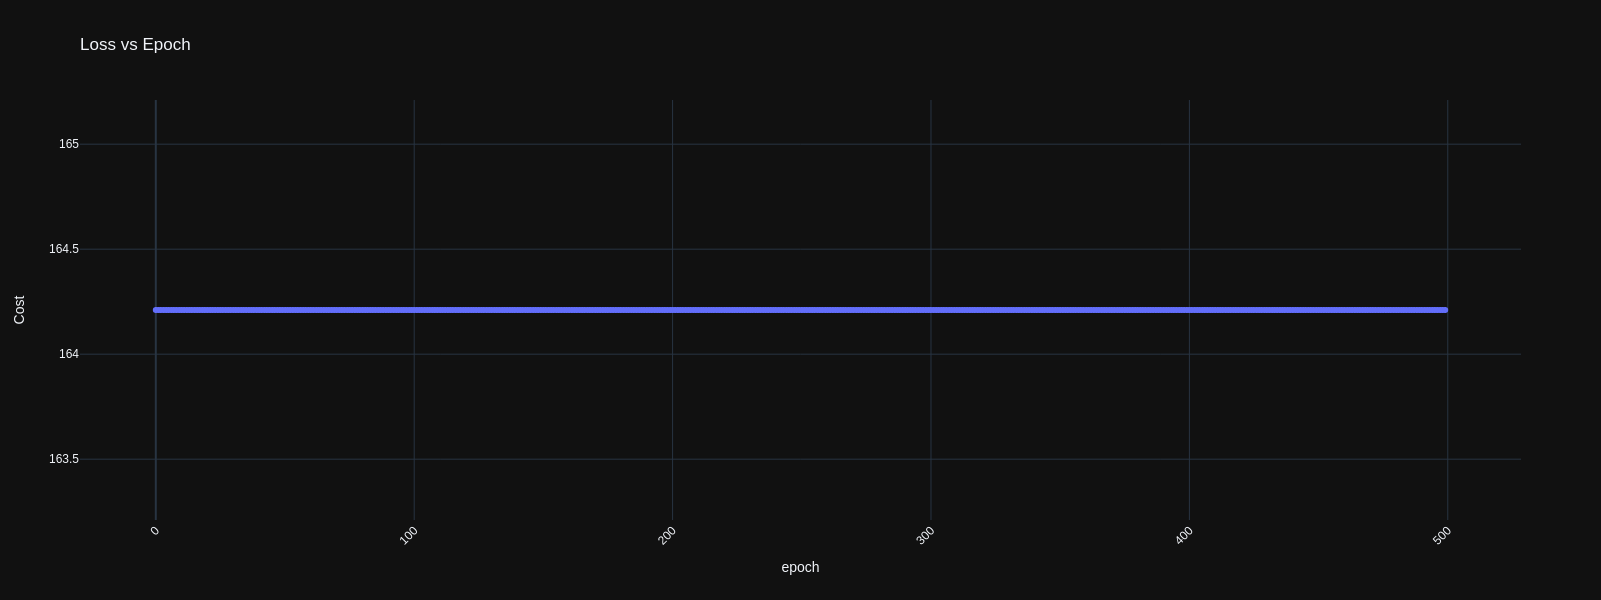

In [79]:
fig = px.line(
    ep_cost, 
    y="least_cost", 
    x="epoch", 
    labels={
        "least_cost": "Cost"
    },
    height=600,
    markers=True,
    title="Loss vs Epoch", 
)
fig.layout.template = "plotly_dark"
fig.update_xaxes(
    tickangle = -45,
)
fig.show()

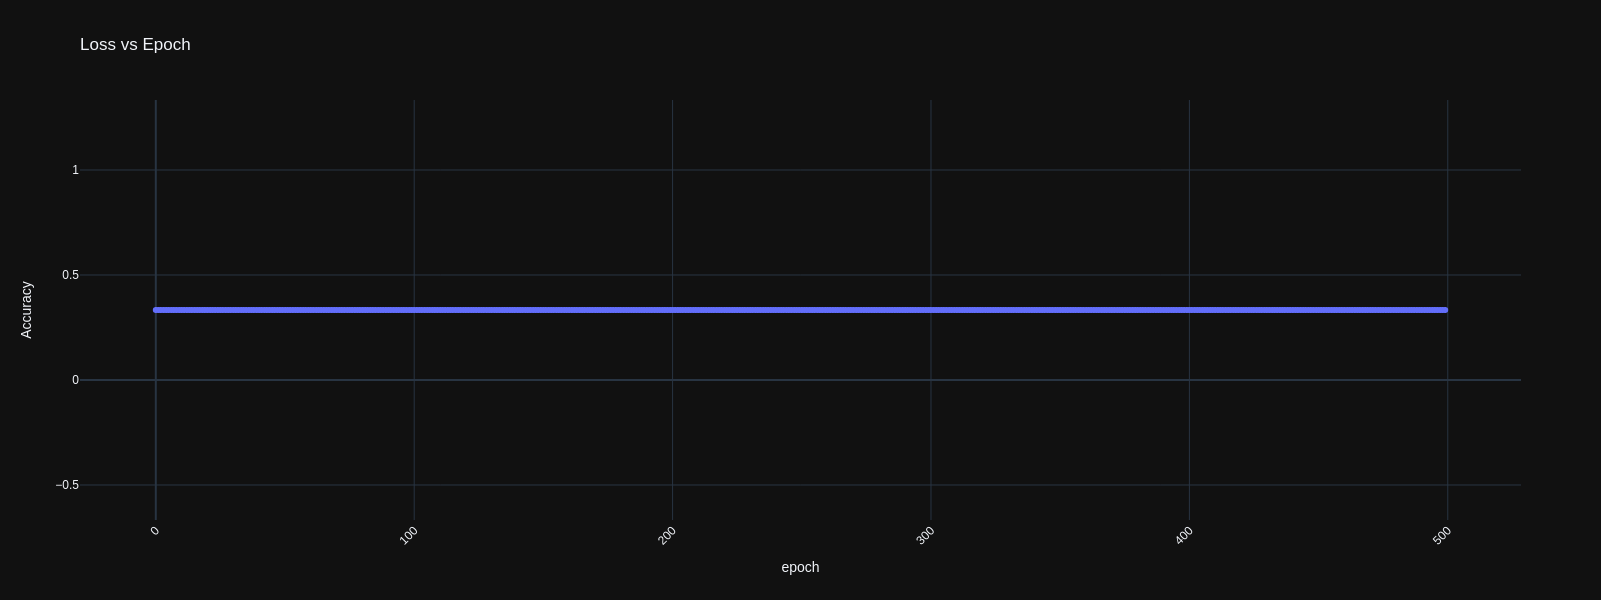

In [80]:
fig = px.line(
    ep_cost, 
    y="accuracy", 
    x="epoch", 
    labels={
        "accuracy": "Accuracy"
    },
    height=600,
    markers=True,
    title="Loss vs Epoch", 
)
fig.layout.template = "plotly_dark"
fig.update_xaxes(
    tickangle = -45,
)
fig.show()

In [81]:
pred = nn.forward(x_train)
print(softmax(pred))
nn.export()

[[0.33381664 0.33305611 0.33312725]
 [0.33376495 0.33308482 0.33315023]
 [0.33374099 0.33309883 0.33316017]
 [0.33374365 0.33309703 0.33315932]
 [0.33380855 0.33306083 0.33313062]
 [0.33394399 0.33298447 0.33307154]
 [0.33375676 0.33308997 0.33315327]
 [0.33380878 0.33306032 0.33313089]
 [0.33370334 0.33311999 0.33317667]
 [0.33377114 0.33308136 0.33314751]
 [0.33387774 0.33302141 0.33310085]
 [0.33379318 0.33306909 0.33313773]
 [0.33374441 0.33309658 0.33315901]
 [0.33366556 0.33314208 0.33319236]
 [0.33389439 0.33301115 0.33309446]
 [0.33397437 0.33296688 0.33305875]
 [0.33387609 0.33302209 0.33310182]
 [0.33382647 0.33305051 0.33312302]
 [0.33397223 0.33296821 0.33305956]
 [0.33385355 0.33303544 0.33311101]
 [0.33389029 0.33301401 0.3330957 ]
 [0.33385983 0.33303182 0.33310835]
 [0.33371568 0.33311363 0.33317069]
 [0.33387115 0.33302455 0.3331043 ]
 [0.3338261  0.33305011 0.33312379]
 [0.33379835 0.33306559 0.33313605]
 [0.33383986 0.33304255 0.33311759]
 [0.33384197 0.33304167 0.33

array([ 0.32160424,  0.00339853,  0.07737081,  0.0722213 ,  0.15911885,
       -0.00995885, -1.0630232 , -0.20488134,  0.77091765,  0.79845249,
       -0.19295786, -0.36338007, -0.05512753, -0.70082327,  0.48778024,
       -0.42931332, -0.28442796, -0.21749204, -0.01954939, -0.05699583,
       -0.08411553,  0.05322281,  0.04154708, -0.1528917 , -0.42838759,
       -0.10172944,  0.08178988, -0.18284631, -0.00513851,  0.67132957,
       -0.21432307, -0.03202741, -0.20624308,  0.37934202, -0.32799275,
        0.24104367,  0.25125566,  0.37233721,  0.27110587,  0.15554357,
       -0.54768217, -0.00820404, -0.48227285, -0.64308512, -0.95517615,
        0.36149342,  0.08876616,  0.4800545 ,  0.48264962, -0.32815629,
        0.54814391,  0.11840148,  1.05807146, -0.08789915,  0.44226001,
        0.10652187,  0.01055891,  0.46021315, -0.7595854 ,  0.41020699,
       -0.59596844,  0.41539569, -0.02563596,  0.14736065, -0.36870878,
       -0.48281331, -0.33051031,  0.26349193, -0.00519743,  0.32